In [273]:
import test_config as cfg
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import os, os.path
import pickle
import io

import skimage
import skimage.io, skimage.transform, skimage.filters
import scipy.ndimage

import sys
sys.path.append(r'../src/')

import importlib
import transform
import filters
import local_radon
import skew_line
importlib.reload(transform)
importlib.reload(filters)
importlib.reload(local_radon)
importlib.reload(skew_line)

<module 'skew_line' from '../src\\skew_line.py'>

In [275]:
%%time
src_fname = os.path.join(cfg.sample_path, os.listdir(cfg.sample_path)[6])
print(src_fname)
src = skimage.io.imread(src_fname, as_grey=True)

src2 = skimage.transform.rescale(src, scale=0.05)

D:/Data/bujo_sample\20190309_125151.jpg
Wall time: 819 ms


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


C:\Anaconda3\lib\site-packages\skimage\transform\radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


Text angles is 0.0
Text line delta is 9
Wall time: 264 ms


C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


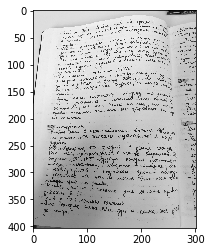

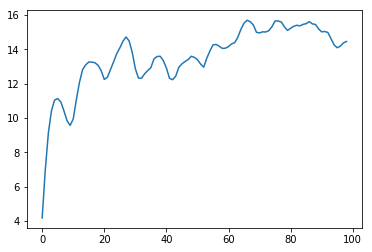

In [276]:
%%time
text_angle = transform.get_text_angle(src2)
print('Text angles is {}'.format(text_angle[0][0]))

src3 = skimage.transform.rotate(skimage.transform.rescale(src, scale=0.1), -90.0-text_angle[0][0], resize=True)
plt.figure()
plt.imshow(src3, cmap='gray')

text_line_delta, text_line_deltas = transform.get_text_line_delta(src3)
plt.figure()
plt.plot(text_line_deltas)
print('Text line delta is {}'.format(text_line_delta))

Wall time: 49 ms


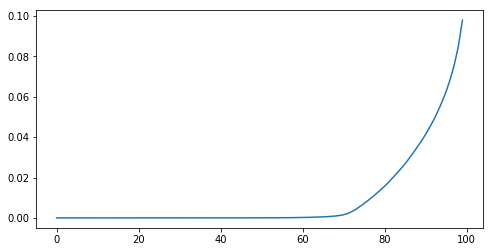

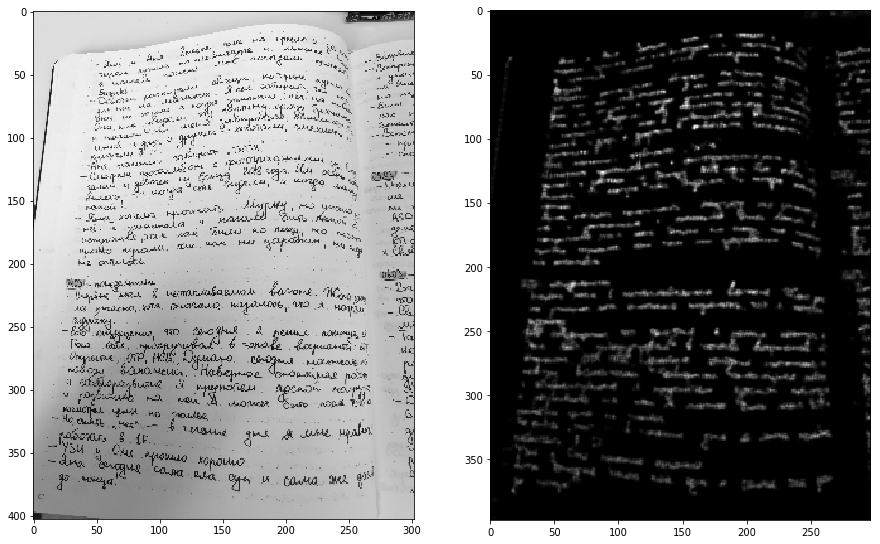

In [277]:
%%time
src4 = transform.filter_variance(src3, (text_line_delta//2, text_line_delta//2), 50, 50)
text_cutoff = np.percentile(src4, 90)/2

plt.figure(figsize=(8,4))
plt.plot(np.percentile(src4, range(100)))

plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(src3, cmap='gray')
plt.subplot(122)
plt.imshow(src4, cmap='gray')

C:\Anaconda3\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


[(-1.5466302294595904, -64.0, 0, 162, 1677)]
Wall time: 99.9 ms


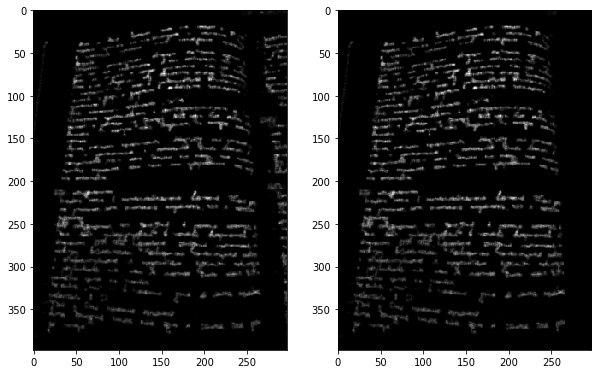

In [278]:
%%time
src5 = skimage.transform.rescale(src4>text_cutoff, scale=0.25)>0.0
src6 = skimage.filters.gaussian(src5, sigma=0.2)>0.4

vsplits = transform.search_region_vsplit(src6, np.pi*3/8, num_angles=131,
                                         window_size_1d=15, max_value=2, zero_threshold=10,
                                         min_split_abs=100, max_split_pct=0.10)

src7 = transform.erase_regions(src4, vsplits, dsz=4)
print(vsplits)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(src4, cmap='gray')
plt.subplot(122)
plt.imshow(src7, cmap='gray')

(7, 48) (116, 167) 0.20943951023931962 1589.6642057119705 2.5991103697525717 0.14586322333811574
(5, 46) (126, 177) 0.17453292519943298 1197.1763252442788 2.2627646326276465 0.13199426111908177
(4, 45) (136, 187) 0.13962634015954634 1081.6119454012746 2.1497975708502026 0.13055954088952654
(3, 44) (146, 197) 0.10471975511965981 1061.4293220804905 2.0587875076546234 0.1358201817312291
(2, 43) (156, 207) 0.03490658503988664 1239.8137645438223 2.3062003179650237 0.14203730272596843
(2, 43) (166, 217) 0.0 1381.7146653689367 2.4618202310510005 0.1449067431850789
(2, 43) (176, 227) -0.03490658503988653 1318.7169559287095 2.162815405046481 0.14968914395026303
(2, 43) (186, 237) -0.13962634015954634 1106.5388988834422 1.6586405818911463 0.14681970349115256
(5, 46) (196, 247) -0.13962634015954634 1267.2742741727043 1.5996507857321027 0.15064562410329985
(6, 47) (206, 257) -0.27925268031909267 800.9421580479968 1.45136186770428 0.10903873744619799
(11, 52) (215, 266) -0.3839724354387525 439.8203

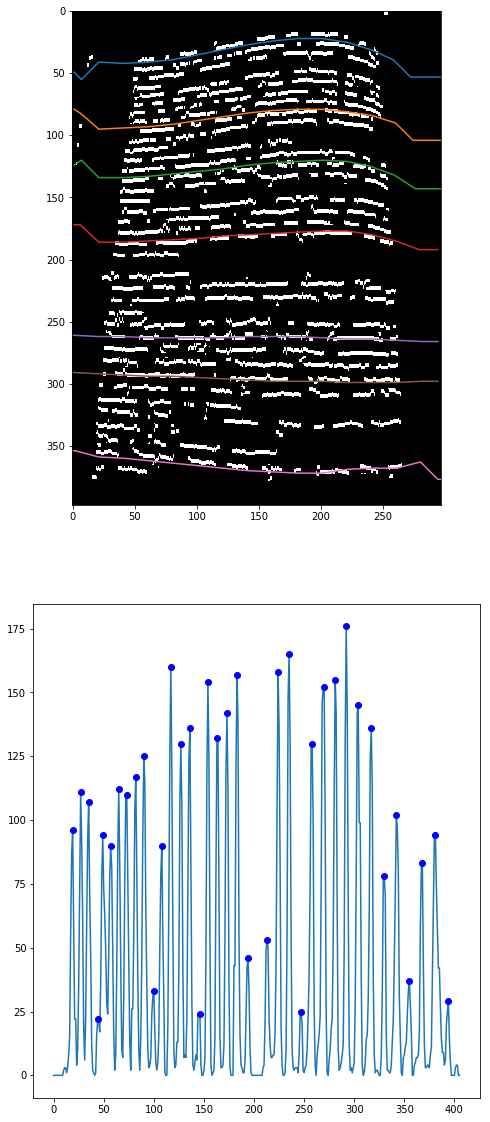

In [279]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50), reg_coef=1.7, reg_power=0.5)

ires, imeta = skew_line.integrate_curves(src8, curves)
ids = skew_line.select_line_candidates(ires, text_line_delta//2, min_value=20, minmax_ratio=0.8)

plt.figure(figsize=(8,20))
plt.subplot(211)
plt.imshow(src8, cmap='gray')
for crv in curves:
    plt.plot(crv[:,1], crv[:,0])
    
plt.subplot(212)
plt.plot(ires)
for i in ids:
    plt.plot(i, ires[i], 'bo')

Wall time: 61.1 ms


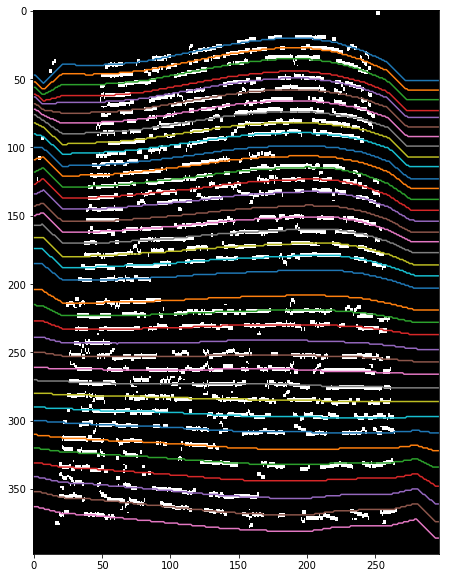

In [280]:
%%time
plt.figure(figsize=(8,10))
plt.imshow(src8, cmap='gray')
all_curves = []
for i in ids:
    if len(imeta[i])>2:
        tmp_j, tmp_i = skew_line.interpolate_between_curves(np.arange(src8.shape[1]), 0, src8.shape[0]-1, imeta[i][0], imeta[i][1], imeta[i][2])
        all_curves.append((tmp_j, tmp_i))
    else:
        tmp_j, tmp_i = skew_line.offset_curve(np.arange(src8.shape[1]), imeta[i][0], imeta[i][1])
        all_curves.append((tmp_j, tmp_i))
    plt.plot(tmp_j, tmp_i)
    #print(type(imeta[i][0]))

In [155]:
def calc_cumulative_integral_with_offset(src, curve_j, curve_i, offsets):
    return np.array([np.cumsum(src[np.minimum(src.shape[0]-1, np.maximum(0, curve_i+offset)), curve_j]) for offset in offsets])

def calc_local_maximas(arr1d):
    msk_max = (arr1d[:-2]<=arr1d[1:-1])&(arr1d[2:]<=arr1d[1:-1])
    return np.arange(1, len(arr1d)-1)[msk_max]

def calc_closest_local_maxima(arr1d, i):
    maxs = calc_local_maximas(arr1d)
    if len(maxs)==0:
        return np.argmax(arr1d)
    idm = np.argmin(np.abs(np.array(maxs)-i))
    return maxs[idm]

def calc_best_offsets(src, curve_j, curve_i, ids, offset):
    arr2d = calc_cumulative_integral_with_offset(src, curve_j, curve_i, np.arange(-offset, offset+1)).T
    arr2d_val = arr2d[ids[1:],:]-arr2d[ids[:-1],:]
    return np.array([calc_closest_local_maxima(x, offset)-offset for x in arr2d_val])

def optimize_curve(src, curve_j, curve_i, pts, offset):
    seg_off = calc_best_offsets(src, curve_j, curve_i, pts, offset)
    print(seg_off)
    seg_id = 0.5*(np.array(pts)[1:]+np.array(pts)[:-1])
    return np.minimum(src.shape[0]-1, np.maximum(0, np.round(np.interp(curve_j, seg_id, seg_off)+curve_i)))

In [164]:
def ascend_offset(arr1d, i):
    if arr1d[i-1] < arr1d[i] and arr1d[i+1] < arr1d[i]:
        return i
    if arr1d[i-1] >= arr1d[i] and arr1d[i+1] >= arr1d[i]:
        if arr1d[i-1]>arr1d[i+1]:
            adir = arr1d[:(i+1)][::-1]
            ddir = -1
        else:
            adir = arr1d[i:]
            ddir = +1
    elif arr1d[i-1] > arr1d[i]:
        adir = arr1d[:(i+1)][::-1]
        ddir = -1
    else:
        adir = arr1d[i:]
        ddir = +1
    off = np.argmin(adir[1:]>adir[:-1])
    return i + off*ddir

def calc_offsets_by_midpoint(arr2d, offset, min_window):
    if arr2d.shape[0] < min_window:
        return None
    midpoint = arr2d.shape[0] // 2
    arr_l = arr2d[midpoint,:] - arr2d[0,:]
    arr_r = arr2d[-1,:] - arr2d[midpoint,:]
    off_l = ascend_offset(arr_l, offset)
    off_r = ascend_offset(arr_r, offset)
    return (off_l, off_r, calc_offsets_by_midpoint(arr2d[:midpoint], off_l, min_window), calc_offsets_by_midpoint(arr2d[midpoint:], off_r, min_window))

def convert_tree_to_linear(x0, x1, offset_tree):
    if offset_tree is None:
        return []
    if offset_tree[2] is None:
        l_part = [(x0*0.75+x1*0.25, offset_tree[0])]
    else:
        l_part = convert_tree_to_linear(x0, (x0+x1)*0.5, offset_tree[2])
        
    if offset_tree[3] is None:
        r_part = [(x0*0.25+x1*0.75, offset_tree[1])]
    else:
        r_part = convert_tree_to_linear((x0+x1)*0.5, x1, offset_tree[3])
    
    return l_part+r_part

def optimize_curve_bin(src, crv_j, crv_i, offset, min_window):
    loc_arr2d = calc_cumulative_integral_with_offset(src, crv_j, crv_i, np.arange(-offset, offset+1)).T
    tree_off = calc_offsets_by_midpoint(loc_arr2d, offset, min_window)
    off_ji = np.array(convert_tree_to_linear(0, src.shape[1]-1, tree_off))
    new_i = np.minimum(src.shape[0]-1, np.maximum(0, np.round(crv_i + np.interp(crv_j, off_ji[:,0], off_ji[:,1]) - offset))).astype(int)
    return new_i

In [90]:

def integrate_between_curves_v2(src, crv1, crv2):
    """Calculates integral over interpolated curves. Number of midpoints corresponds to largest distance between crv1 and crv2.

    Keyword arguments:
    src -- source map (2d-array)
    crv1, crv2 -- curves as list of (i, j)-coordinates
        
    Returns array of values and array of a-coefs of linear interpolation
    """
    j_s = np.arange(src.shape[1])
    i1_s = np.interp(j_s, crv1[:,1], crv1[:,0])
    i2_s = np.interp(j_s, crv2[:,1], crv2[:,0])
    num = np.max(np.abs(i1_s-i2_s))
    alphas = np.linspace(0, 1, num)
    ias = [np.minimum(src.shape[0]-1, np.maximum(0, np.floor(0.5+i1_s*(1-a)+a*i2_s))) for a in alphas]
    return np.array([np.cumsum(src[i_s.astype(int), j_s]) for i_s in ias]), alphas

def integrate_offsets_curve_v2(src, crv, dvs):
    """Calculates integral over offsets of curve.

    Keyword arguments:
    src -- source map (2d-array)
    crv -- curve as list of (i, j)-coordinates
    dvs -- array of i-offsets
        
    Returns array of values and array of offsets
    """
    j_s = np.arange(src.shape[1])
    i_s = np.floor(0.5+np.interp(j_s, crv[:,1], crv[:,0])).astype(int)
    return np.array([np.cumsum(src[np.minimum(src.shape[0]-1, np.maximum(0, i_s+d)), j_s]) for d in dvs]), dvs

def integrate_curves_v2(src, curves):
    """Calculates integrals over offsets of first and last curve and interpolation of all other.

    Keyword arguments:
    src -- source map (2d-array)
    curves -- list of curves as list of (i, j)-coordinates
        
    Returns array of values and array of meta information (c1,c2,a) for interpolation and (c,offset) for offset
    """
    res0 = []
    res1 = []
    df = np.min(curves[0][:,0])
    irf, dsf = integrate_offsets_curve_v2(src, curves[0], -np.arange(df)[::-1])
    res0 += irf.tolist()
    res1 += [(curves[0], d) for d in dsf]
    for (c1,c2) in zip(curves[:-1], curves[1:]):
        ir_s, a_s = integrate_between_curves_v2(src, c1, c2)
        res0 += ir_s.tolist()
        res1 += [(c1, c2, a) for a in a_s]
    dl = src.shape[0]-np.max(curves[-1][:,0])
    irl, dsl = integrate_offsets_curve_v2(src, curves[-1], np.arange(dl))
    res0 += irl.tolist()
    res1 += [(curves[-1], d) for d in dsl]
    return np.array(res0), res1

6

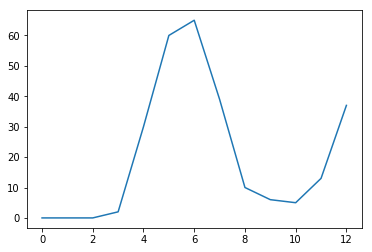

In [132]:
tmp_offsets = np.arange(-6, 7)
tmp1 = calc_cumulative_integral_with_offset(src8, all_curves[4][0], all_curves[4][1], tmp_offsets).T
midpoint = (src8.shape[1]-1)//2
tmp21 = tmp1[midpoint,:]
tmp22 = tmp1[-1,:]-tmp1[midpoint,:]
plt.plot(tmp22)
#calc_closest_local_maxima(tmp2, 10)
ascend_offset(tmp22, 6)

In [144]:
np.array(convert_tree_to_linear(0, 296, calc_offsets_by_midpoint(tmp1, 6, 10)))

array([[  4.625 ,   9.    ],
       [ 13.875 ,   9.    ],
       [ 23.125 ,   9.    ],
       [ 30.0625,   9.    ],
       [ 34.6875,   9.    ],
       [ 41.625 ,   9.    ],
       [ 50.875 ,   9.    ],
       [ 60.125 ,   9.    ],
       [ 67.0625,   9.    ],
       [ 71.6875,   9.    ],
       [ 78.625 ,   8.    ],
       [ 87.875 ,   8.    ],
       [ 97.125 ,   8.    ],
       [104.0625,   8.    ],
       [108.6875,  10.    ],
       [115.625 ,   6.    ],
       [124.875 ,   6.    ],
       [134.125 ,   6.    ],
       [141.0625,   6.    ],
       [145.6875,   6.    ],
       [152.625 ,   6.    ],
       [161.875 ,   6.    ],
       [171.125 ,   6.    ],
       [178.0625,   6.    ],
       [182.6875,   6.    ],
       [189.625 ,   5.    ],
       [198.875 ,   5.    ],
       [208.125 ,   5.    ],
       [215.0625,   5.    ],
       [219.6875,   5.    ],
       [226.625 ,   6.    ],
       [235.875 ,   6.    ],
       [245.125 ,   6.    ],
       [252.0625,   6.    ],
       [256.68

In [92]:
%%time
src8 = filters.local_maxima_v(src7, 1, text_line_delta//2, text_cutoff)*1.0

curves = skew_line.create_support_curves(src8, 20, (40, 50), reg_coef=np.mean(src8))

ires, imeta = integrate_curves_v2(src8, curves)

Wall time: 940 ms


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


In [97]:
%%time
ids = skew_line.select_line_candidates(ires[:,-1], text_line_delta//2, min_value=20, minmax_ratio=0.8)

Wall time: 2 ms


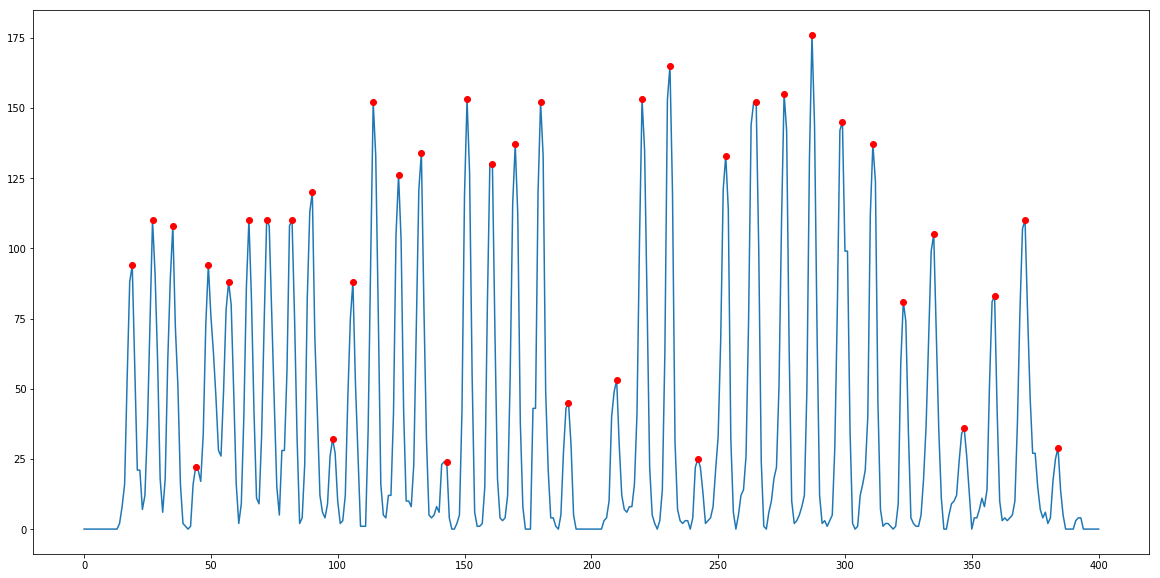

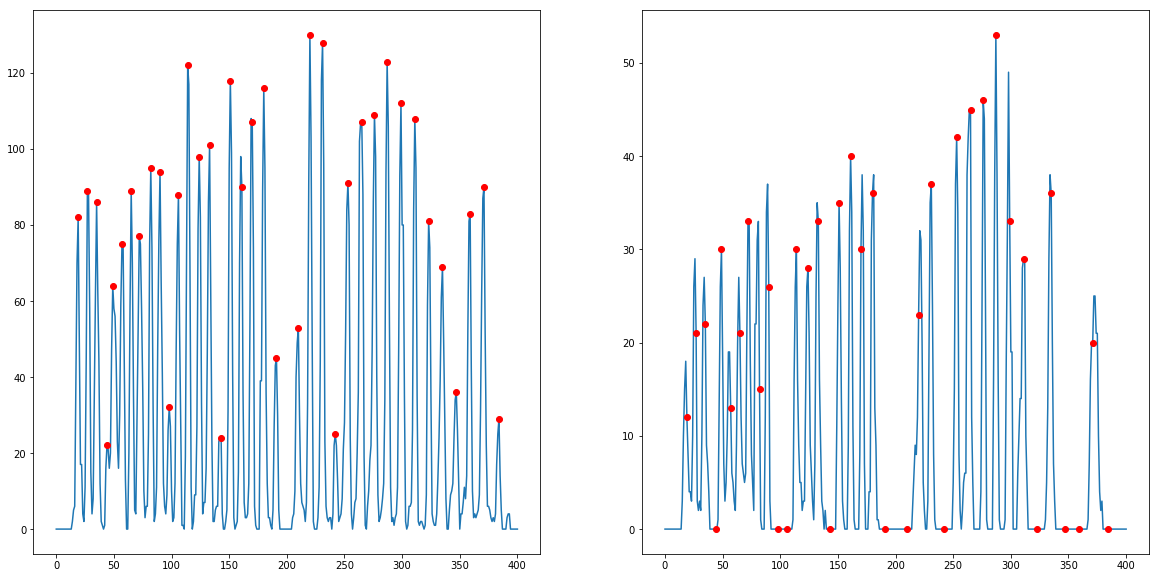

In [106]:
plt.figure(figsize=(20,10))
plt.plot(ires[:,-1])
plt.plot(ids, ires[ids, -1], 'ro')

midpoint = (ires.shape[0]-1)//2
ires1 = ires[:, midpoint]
ires2 = ires[:, -1] - ires[:, midpoint]

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(ires1)
plt.plot(ids, ires1[ids], 'ro')

plt.subplot(122)
plt.plot(ires2)
plt.plot(ids, ires2[ids], 'ro')

Wall time: 121 ms


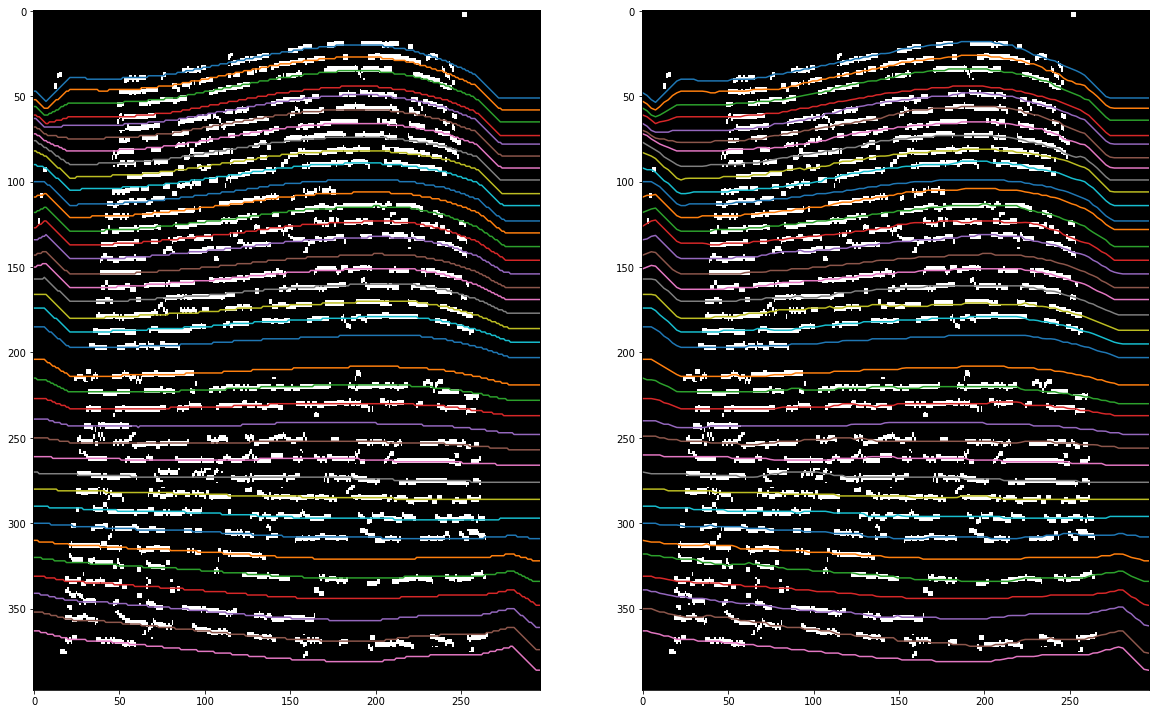

In [266]:
%%time
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.imshow(src8, cmap='gray')
for curve in all_curves:
    plt.plot(curve[0], curve[1])

plt.subplot(122)
plt.imshow(src8, cmap='gray')
for curve in all_curves:
    opt_curve_is = optimize_curve_bin(src8, curve[0], curve[1], 6, 20)
    true_j = np.linspace(0, src8.shape[1]-1, 120)
    true_i = np.interp(true_j, curve[0], opt_curve_is)
    plt.plot(true_j, true_i)

In [51]:
calc_closest_local_maxima(tmp2, len(tmp2)//2)

10

In [42]:
len(msk_ext[:8]), len(msk_ext[7:])

(8, 8)

In [64]:
np.arange(20, src8.shape[1]-10, 50)

array([ 20,  70, 120, 170, 220, 270])

In [44]:
msk_ext[:8]

array([False, False, False,  True, False, False,  True, False])

In [52]:
15//2

7